In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, mannwhitneyu
from pprint import pprint


# Embedding Method Comparison

In [211]:
def create_combined_privacy_df(model_list, dataset, train_ratios, snp_nums, seeds, density_embedding_combos):
    """
    Create DataFrames summarizing accuracy and AUC for different attacks by combining
    results from different density_estimator and embedding_method configurations.
    
    The privacy_logger.pkl files are assumed to be stored under:
       ../results_folder/{dataset}/{model}/{density_estimator}_{embedding_method}_privacy_logger_2.pkl
    
    Each privacy_logger contains keys in the form:
       "{density_estimator}_{embedding_method}_{snp}_{train_ratio}"
       
    Parameters:
      model_list: list of model names (e.g., ['ctgan'])
      dataset: dataset name (e.g., 'human1000')
      train_ratios: list of training ratios (e.g., [0.25, 0.5, 0.75])
      snp_nums: list of SNP numbers (e.g., [200, 500, 1000])
      seeds: list of seeds (e.g., [0, 42, 50, 100, 245])
      density_embedding_combos: list of tuples, e.g., [("bnaf", "umap"), ("kde", "pca"), ...]
      
    Returns:
      Two DataFrames: one for accuracy metrics and one for AUC metrics.
    """
    import pickle
    import pandas as pd
    all_rows = []
    all_rows_auc = []
    
    
    
    for model in model_list:
        for density_estimator, embedding_method in density_embedding_combos:
            file_path = f'../results_folder/{dataset}/{model}/{density_estimator}_{embedding_method}_privacy_logger_2.pkl'
            try:
                with open(file_path, 'rb') as pf:
                    privacy_logger = pickle.load(pf)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                continue
            
            # Expected key format: "{density_estimator}_{embedding_method}_{snp}_{train_ratio}"
            prefix = f"{density_estimator}_{embedding_method}_"
            for config_key, config_data in privacy_logger.items():
                if not config_key.startswith(prefix):
                    continue
                
                # Remove the prefix; the remainder should be "{snp}_{train_ratio}"
                remainder = config_key[len(prefix):]
                try:
                    snp_str, train_ratio_str = remainder.split('_')
                    snp = int(snp_str)
                    tr = float(train_ratio_str.replace('_', '.'))
                except Exception as e:
                    print(f"Error parsing key {config_key}: {e}")
                    continue
                
                if snp not in snp_nums or tr not in train_ratios:
                    continue
                
                # Process each seed
                for seed in seeds:
                    seed_key_baseline = f"{seed}_Baselines"
                    if seed_key_baseline not in config_data:
                        continue
                    baseline_results = config_data[seed_key_baseline]
                    try:
                        LOGAN_d1_acc = baseline_results["LOGAN_D1"]["accuracy"]
                        LOGAN_d1_auc = baseline_results["LOGAN_D1"]["aucroc"]
                        gan_leaks_acc = baseline_results["gan_leaks"]["accuracy"]
                        gan_leaks_auc = baseline_results["gan_leaks"]["aucroc"]
                        mc_acc = baseline_results["MC"]["accuracy"]
                        mc_auc = baseline_results["MC"]["aucroc"]
                    except KeyError as e:
                        print(f"Missing baseline key for {config_key}, seed {seed}: {e}")
                        continue
                    
                    # For DOMIA (Eqn2), assume keys: "{seed}_Eqn2" and "{seed}_Eqn2AUC"
                    domias_acc = config_data.get(f"{seed}_Eqn2", None)
                    domias_auc = config_data.get(f"{seed}_Eqn2AUC", None)
                    
                    naive_acc = config_data.get(f"{seed}_Eqn1", None)
                    naive_auc = config_data.get(f"{seed}_Eqn1AUC", None)
                    
                    row_acc = [model, density_estimator, embedding_method, tr, snp, seed,
                               LOGAN_d1_acc, gan_leaks_acc, mc_acc, domias_acc, naive_acc]
                    row_auc = [model, density_estimator, embedding_method, tr, snp, seed,
                               LOGAN_d1_auc, gan_leaks_auc, mc_auc, domias_auc, naive_auc]
                    
                    all_rows.append(row_acc)
                    all_rows_auc.append(row_auc)
    
    df = pd.DataFrame(all_rows, columns=['Model', 'Density Estimator', 'Embedding Method', 'Train Ratio', 'SNP number', 'Seed', 
                                          'LOGAN_D1_acc', 'GAN-leaks_acc', 'MC_acc', 'DOMIA_acc', 'Naive_auc'])
    df_auc = pd.DataFrame(all_rows_auc, columns=['Model', 'Density Estimator', 'Embedding Method', 'Train Ratio', 'SNP number', 'Seed', 
                                                  'LOGAN_D1_auc', 'GAN-leaks_auc', 'MC_auc', 'DOMIA_auc', 'Naive_auc'])
    return df, df_auc

In [212]:
def mean_std(x):
    mean = x.mean()
    std = x.std()
    return f'{mean:.3f} ({std:.3f})'


In [252]:
models = ['ctgan']
models_names = ['CTGAN']
snp_numbers = [200, 500, 1000]
train_ratios = [0.25, 0.5, 0.75]

out_folder = '../../results_folder/'
dataset = 'human1000'

df_acc, df_auc = create_privacy_df(['ctgan','bitdiffusion'], dataset,'insig', [0.25, 0.5, 0.75], [200, 500, 1000],
                                  [0, 42, 50, 100, 245])

group_cols = ["Model", "Embedding Method", "Train Ratio", "SNP number"]

# Identify the numeric columns (the MIA metrics):
attacks = ["LOGAN_D1_auc", "GAN-leaks_auc", "MC_auc", "DOMIA_auc", "Naive_auc"]

# Combine density estimator & embedding method into a single label
df_auc["Combo"] = df_auc["Density Estimator"] + "+" + df_auc["Embedding Method"]

models = ['ctgan']
model_names = ['CTGAN']  # to display on the plot
snp_numbers = [200, 500, 1000]
train_ratios = [0.25, 0.5, 0.75]


# We'll group by Model, Embedding Method, Train Ratio, SNP number and take mean across seeds

#auc_scores = df_auc.groupby(['Model','Density Estimator','Embedding Method','Train Ratio', 'SNP number']).agg(mean_std).reset_index()

df_heat = df_auc.groupby(["Combo",'Train Ratio', 'SNP number'])[attacks].mean().reset_index()
# df_heatmap = df_heat.set_index("Combo")

In [253]:
df_heat

,Combo,Train Ratio,SNP number,LOGAN_D1_auc,GAN-leaks_auc,MC_auc,DOMIA_auc,Naive_auc
0,bnaf+pca,0.50,200,0.505684,0.505347,0.503763,0.500000,0.500000
1,bnaf+pca,0.50,500,0.507964,0.503985,0.497343,0.500000,0.500000
2,bnaf+pca,0.50,1000,0.495527,0.502492,0.497870,0.500000,0.500000
3,bnaf+pca,0.75,200,0.500494,0.513878,0.511895,0.500000,0.500000
4,bnaf+pca,0.75,500,0.549464,0.496564,0.497444,0.500000,0.500000
5,bnaf+pca,0.75,1000,0.539412,0.500253,0.494870,0.500000,0.500000
6,discrete_kde+pca,0.50,200,0.493556,0.504979,0.500061,0.501848,0.504985
7,discrete_kde+pca,0.50,500,0.494915,0.506208,0.503297,0.505902,0.506031
8,discrete_kde+pca,0.50,1000,0.495391,0.504837,0.497641,0.504807,0.504807
9,discrete_kde+pca,0.75,200,0.486853,0.512363,0.510938,0.510473,0.511918


# 3.1 graphs

In [72]:
import matplotlib.gridspec as gridspec
import os, pickle, pathlib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import matplotlib.lines as mlines


In [9]:
import pickle, pathlib, itertools, json, os
import numpy  as np
import pandas as pd
from tqdm.auto import tqdm

# ------------------------------------------------------------------ config --
BASE_RESULTS = pathlib.Path("../../results_folder")     # adapt if different

# a *minimal* manifest so the script knows what to iterate over.
# Fill in any extra snp / ratio / seed combinations you have.
metrics_cfg = {
    "eyecolor":  dict(snp=[200,500,1000], ratio=[0.5,0.75],  seeds=[0,1,2,3,4]),
    "human1000": dict(snp=[200,500,1000], ratio=[0.25,0.5,0.75], seeds=[0,1,2,3,4]),
}

MODELS   = ["ctgan", "bitdiffusion", "Train"]        # add others if present
MODEL0   = "ctgan"                                   # folder where GT/Train etc. sit


# ---------------------------------------------------------------- utilities -

def collect_metrics():
    rows = []
    for ds,(snp_lst,ratio_lst,seeds) in tqdm([(k,(v["snp"],v["ratio"],v["seeds"]))
                                              for k,v in metrics_cfg.items()]):
        for snp,ratio,model,seed in itertools.product(snp_lst,ratio_lst,MODELS,seeds):
            maf  = load_metric(model, ds, snp, ratio, seed, metric="maf",
                               model0=MODEL0)
            het  = load_metric(model, ds, snp, ratio, seed, metric="het",
                               model0=MODEL0)
            if maf is None:           # missing pickle – skip row
                continue
            rows.append(dict(Dataset=ds, Model=model,
                             **{"SNP number":snp, "Train Ratio":ratio,
                                "Seed":seed, "maf_value":maf, "het_value":het}))
    return pd.DataFrame(rows)


def build_summary(df_metrics, out_csv=False):
    """
    Wrapper around your `analyze_metric_table()` to loop over
    both datasets and concatenate the results.
    """
    summary_frames = []
    for ds in df_metrics.Dataset.unique():
        for metric in ["maf"]:                    # extend if you need het stats too
            summ = analyze_metric_table(
                      df_metrics.query("Dataset==@ds"), metric=metric)
            summ.insert(0,"Dataset",ds)
            summary_frames.append(summ)
    summary = pd.concat(summary_frames, ignore_index=True)
    if out_csv:
        summary.to_csv("summary_metrics.csv", index=False)
    return summary


if __name__ == "__main__":

    # 1) build the long table ------------------------------------------------
    df_metrics = collect_metrics()
    df_metrics.to_pickle("metrics_long.pkl")
    print("✓ saved metrics_long.pkl  – rows:", len(df_metrics))

    # 2) build the summary (Δ-MAF stats) ------------------------------------
    df_summary = build_summary(df_metrics)
    df_summary.to_pickle("summary_metrics.pkl")
    print("✓ saved summary_metrics.pkl – rows:", len(df_summary))

  0%|          | 0/2 [00:00<?, ?it/s]

NameError: name 'load_metric' is not defined

In [10]:
df_metrics  = pd.read_pickle("metrics_long.pkl")
df_summary  = pd.read_pickle("summary_metrics.pkl")

In [ ]:
# ------------------------------------------------------------------- #
# ───────── helper : one global colour palette & model order
# ------------------------------------------------------------------- #
MODELS   = ("ctgan", "bitdiffusion", 'Train')
ModelNAMEs = ['CTGAN', 'DNADiffusion', 'Train']
COLORS   = ( "#3288bd", '#66c2a5',"#d53e4f")       # red vs blue
DATASETS = ("eyecolor", "human1000")
DAtasetNAme = ['OpenSNP', '1kGB']
DS_COL   = {"eyecolor":"#f46d43", "human1000":"#3288bd"}   # for panel-B
DS_name   = {"eyecolor":"OpenSNP", "human1000":"1kGP"}   # for panel-B


# ------------------------------------------------------------------- #
# ─────────  universal SNP-order (ascending TRAIN MAF)  -------------- #
# ------------------------------------------------------------------- #
def maf_sort_index(df, snp, ratio):
    """Return np.argsort order based on TRAIN-set MAF."""
    train_maf = (
        df.query("Model=='Train' and `SNP number`==@snp and `Train Ratio`==@ratio")
          .iloc[0]["maf_value"]
    )
    return np.argsort(train_maf)


# ------------------------------------------------------------------- #
# ─────────  Panel-A  &  Panel-C (same x-order)  --------------------- #
# ------------------------------------------------------------------- #
def plot_lines(ax, df, ds, snp, ratio, metric):
    """Draw mean ± range lines for MAF (ax_maf) and %Het (ax_het)."""
    sub      = df.query("Dataset==@ds and `SNP number`==@snp and `Train Ratio`==@ratio")
    sort_ix  = maf_sort_index(sub, snp, ratio)

    # ---------- MAF
    if metric == 'MAF':
        for m, c, lbl in zip(MODELS, COLORS, ModelNAMEs):
            arr = np.mean(np.stack(sub.loc[sub.Model==m,"maf_value"]), axis=0)[sort_ix]
            ax.plot(arr, lw=1.3, color=c, label=lbl)
            
       # ax.set_title(DS_name[ds], weight='bold', fontsize = 14)
        
        #if ds == 'human1000':
        ax.set_xlabel('SNP Index (sorted by train-MAF)', fontsize = 14)
            
        ax.text(
            0.4, -0.25, DS_name[ds],        # x, y in axis coordinates
                transform=ax.transAxes,         # so 0.0 means left-aligned in axes
            ha='left', va='top',
            fontsize=12, weight = 'bold'
        )
            
        ax.set_ylabel("MAF", fontsize = 14);   ax.set_xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # ---------- Het
    else:
        
        het_train = np.mean(np.stack(sub.loc[sub.Model == 'Train', "het_value"]),
                          axis=0)
        start_x = 1
        end_x = start_x + len(het_train) - 1  
        x_axis = range(start_x, end_x + 1)  

        
        ax.plot(x_axis, het_train, label= 'Train', color=COLORS[-1], linewidth=1.5)
        
        start_x = end_x + 1
        
        for m, c, lbl in zip(MODELS[:-1], COLORS[:-1], ModelNAMEs[:-1]):
            het = np.mean(np.stack(sub.loc[sub.Model == m, "het_value"]),
                          axis=0)
            
            if len(het) > len(het_train):
                np.random.seed(42)
                sampled_mean_metric = np.random.choice(het, \
                                                            size=len(het_train), replace=False)
                
            x_axis = np.arange(len(sampled_mean_metric))
            end_x = start_x + len(sampled_mean_metric) - 1  
        
            x_axis = range(start_x, end_x + 1)  

            ax.plot(x_axis, sampled_mean_metric, label =lbl, color=c, linewidth=1.5)
            start_x = end_x + 1  
            
#         handles = [plt.Line2D([0], [0], color=color, lw=1.5, label=model) for model, color in zip(ModelNAMEs, COLORS)]
#         plt.legend(handles=handles, prop={"size":34, "weight":'bold'}, frameon = False, loc = "lower right")

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(left=0.05)
        ax.set_xlabel("Sample Index", fontsize = 14);   ax.set_xticks([])
        ax.text(
                0.4, -0.25, DS_name[ds],        # x, y in axis coordinates
                    transform=ax.transAxes,         # so 0.0 means left-aligned in axes
                ha='left', va='top',
                fontsize=12, weight = 'bold'
        )
#         ax.set_title(ds.upper(), weight='bold', pad=2)
        ax.set_ylabel("% Hetero.", fontsize = 14);   ax.set_xticks([])
       

#        # axes.text(-0.1, 0.5, str(snp_num), transform=axes.transAxes, fontsize=24, ha='left')
#         plt.xlabel('Sample Index', fontdict={"size":40, "weight":'bold'})
#         plt.ylabel('% Heterogeneity', fontdict={"size":34, "weight":'bold'})  # Change 'Metric Value' to your actual metric


# ------------------------------------------------------------------- #
# ─────────  Panel-D  t-SNE helper (works on a provided Axes)  ------- #
# ------------------------------------------------------------------- #
def tsne_axes(ax, dataset, model, snp, ratio, train_color="tab:red", syn_color="tab:blue"):
    """Embed one t-SNE scatter (real=red, syn=blue) in *ax*."""
    # ------ load arrays ---------------------------------------------------
    train = np.load(f"../data/{dataset}/real/{snp}/{ratio}/train_0.npy")[:,:-1].astype(float)
    if model == "ctgan":
        syn = (np.load(f"../data/{dataset}/syn/{model}/{snp}/{ratio}/sample_data_epoch_2000_245.pkl",
                       allow_pickle=True).values[:,:-1])
        syn[syn<0]=0
    else:
        syn = np.load(f"../data/{dataset}/syn/{model}/{snp}/{ratio}/sample_data_epoch_1000_245.npy",
                      allow_pickle=True)[:,:-1]
    # ­----- sample equal sizes -------------------------------------------
    syn = syn[np.random.permutation(len(syn))[:len(train)]]

    # ------ PCA 100 → t-SNE 2D -------------------------------------------
    X   = np.vstack((train, syn))
    X   = PCA(n_components=100).fit_transform(X)
    Y   = TSNE(n_components=2, perplexity=10, n_iter=1000,
               verbose=False, metric='euclidean').fit_transform(X)

    n   = len(train)y
    ax.scatter(*Y[:n].T , s=5, c=train_color, alpha=.30)
    ax.scatter(*Y[n:].T , s=5, c=syn_color  , alpha=.30)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
   # ax.set_title(f"{dataset} – {model}", fontsize=9, pad=1)


def _get_stat(row, column):
    """
    row … DataFrame filtered to one dataset / snp / ratio
    column … 'maf(Relative MAE)'  or  'maf(K-S test stat)'
    Returns a float or np.nan if the cell is missing.
    """
    if row.empty:
        return np.nan
    # the column is a string like  "0.1234 (0.0456)" – take the
    # first token before the blank and cast to float
    return float(row.iloc[0][column].split()[0])


def stat_bar(ax, summary_df, snp, ratio):
    width    = 0.30
    synths   = MODELS[:-1]          # only the synthetic models
    x_ticks  = np.arange(len(synths))

    mae_eye, ks_eye = [], []
    mae_hum, ks_hum = [], []

    for m in synths:
        # EYECOLOR
        e = summary_df.query(
            "Dataset=='eyecolor' and `SNP number`==@snp and `Train Ratio`==@ratio and Method==@m"
        )
        mae_eye.append(_get_stat(e, 'maf(Relative MAE)'))
        ks_eye .append(_get_stat(e, 'maf(K-S test stat)'))

        # HUMAN1000
        h = summary_df.query(
            "Dataset=='human1000' and `SNP number`==@snp and `Train Ratio`==@ratio and Method==@m"
        )
        mae_hum.append(_get_stat(h, 'maf(Relative MAE)'))
        ks_hum .append(_get_stat(h, 'maf(K-S test stat)'))

    # now we have exactly two bars per group
    ax.bar(x_ticks - width/2, mae_eye, width, color="#f46d43", label="RMAE (OpenSNP)")
    ax.bar(x_ticks - width/2, ks_eye,  width, color="#f46d43", alpha=0.3, label="K-S     (OpenSNP)")

    ax.bar(x_ticks + width/2, mae_hum, width, color="#3288bd", label="RMAE (1kGP)")
    ax.bar(x_ticks + width/2, ks_hum,  width, color="#3288bd", alpha=0.3, label="K-S     (1kGP)")

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([m for m in ModelNAMEs[:-1]], fontsize = 14, rotation=10)
    ax.set_ylabel("ΔMAF statistics", fontsize = 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    ax.legend(frameon=False, loc = "best", fontsize=14)
    

def axis_off(ax):
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_frame_on(False)

In [195]:
def big_panel(df, summary_df, snp=200, ratio=0.50, figsize=(12,9)):
    """
    2×2 outer grid – every quadrant equal size, with custom hspace/wspace,
    legends on A and C, and a “D  t-SNE” subtitle above panel D.
    """
    fig = plt.figure(figsize=figsize)
    GS  = gridspec.GridSpec(
        2, 2,
        wspace=0.25,   # a little more horizontal breathing room
        hspace=0.5,   # tighten vertical gaps
        figure=fig
    )

    # ─── A : MAF lines ────────────────────────────────────────────────
    gsA = GS[0,0].subgridspec(2,1,hspace=0.5)
    axA1 = fig.add_subplot(gsA[0,0])
    axA2 = fig.add_subplot(gsA[1,0])
    plot_lines(axA1, df, "eyecolor",  snp, ratio, metric="MAF")
    plot_lines(axA2, df, "human1000", snp, ratio, metric="MAF")

    # add legends to each
    handles, labels = axA2.get_legend_handles_labels()
    axA2.legend(handles, [l for l in ModelNAMEs],     loc="upper left",
        bbox_to_anchor=(0, 1.1), ncol=len(handles),
            frameon=False, fontsize=12)

    title = axA1.set_title("a • Minor-allele-frequency (MAF)", weight="bold", fontsize=16)
    title.set_position([0.5, 1.4])

    # ─── B : ΔMAF bars ────────────────────────────────────────────────
    axB = fig.add_subplot(GS[0,1])
    stat_bar(axB, summary_df, snp, ratio)
   # axB.set_title("b • ΔMAF statistics (vs Train)", loc="left", weight="bold", pad=4)
    
    title = axB.set_title("b • ΔMAF statistics (v.s. Train)", weight="bold", fontsize=16)
    title.set_position([0.5, 1.4])

    # ─── C : %Het lines ─────────────────────────────────────────────────
    gsC = GS[1,0].subgridspec(2,1,hspace=0.5)
    axC1 = fig.add_subplot(gsC[0,0])
    axC2 = fig.add_subplot(gsC[1,0])
    plot_lines(axC1, df, "eyecolor",  snp, ratio, metric="HET")
    plot_lines(axC2, df, "human1000", snp, ratio, metric="HET")

    # legend on the top subplot of C
#     handles, labels = axC1.get_legend_handles_labels()
#     axC1.legend(handles, [l.capitalize() for l in labels],
#                 title="Model", loc="upper right", frameon=False, fontsize=8)

    handles, labels = axC1.get_legend_handles_labels()
    axC1.legend(handles, ['Train', 'CTGAN', 'DNADiffusion'], loc="upper left",
        bbox_to_anchor=(0.63, 0.7),
            frameon=False, fontsize=12)
   
    # axC1.set_title("c • % Heterozygous SNPs", loc="left", weight="bold", pad=4)
    
    title = axC1.set_title("c • % Heterozygous SNPs", weight="bold",fontsize=16)
    title.set_position([0.5, 1.55])
    
    # ─── D : t-SNE grid ─────────────────────────────────────────────────
    rows, cols = 2, len(MODELS)-1
    gsD = GS[1,1].subgridspec(rows, cols, hspace=0.06, wspace=0.08)
    for r, ds in enumerate(DATASETS):
        for c, mdl in enumerate(MODELS[:-1]):
            ax = fig.add_subplot(gsD[r,c])
            tsne_axes(ax, ds, mdl, snp, ratio,
                      train_color="#d73027", syn_color="#4575b4")
          #  ax.set_title(f"{ds} – {mdl}", fontsize=8, pad=2)
        
            # Add model name above top row
            if r == 0:
                ax.set_title(ModelNAMEs[c], fontsize=12, fontweight='bold', pad = 2)

            # Add dataset name as row label on the left
            if c ==0:
                ax.text(-0.02, 0.5, DS_name[ds], transform=ax.transAxes,
                        fontsize=14, fontweight='bold',
                        ha='right', va='center', rotation=90)
    
           
    fig.text(0.6, 0.45, "d • t-SNE", weight="bold", fontsize=16)
    
    train_handle = mlines.Line2D([], [], color="#d73027", marker='o', linestyle='None', markersize=6, label='Train')
    syn_handle   = mlines.Line2D([], [], color="#4575b4", marker='o', linestyle='None', markersize=6, label='Synthetic')
    
    fig.legend(
        handles=[train_handle, syn_handle],
    loc='lower center',
    bbox_to_anchor=(0.7, 0.05),
    ncol=2,
    frameon=False,
    fontsize=14)

    # ─ overall suptitle ────────────────────────────────────────────────
 #   fig.suptitle(f"SNP = {snp}   •   train-ratio = {ratio}", weight='bold', y=0.99)

    return fig

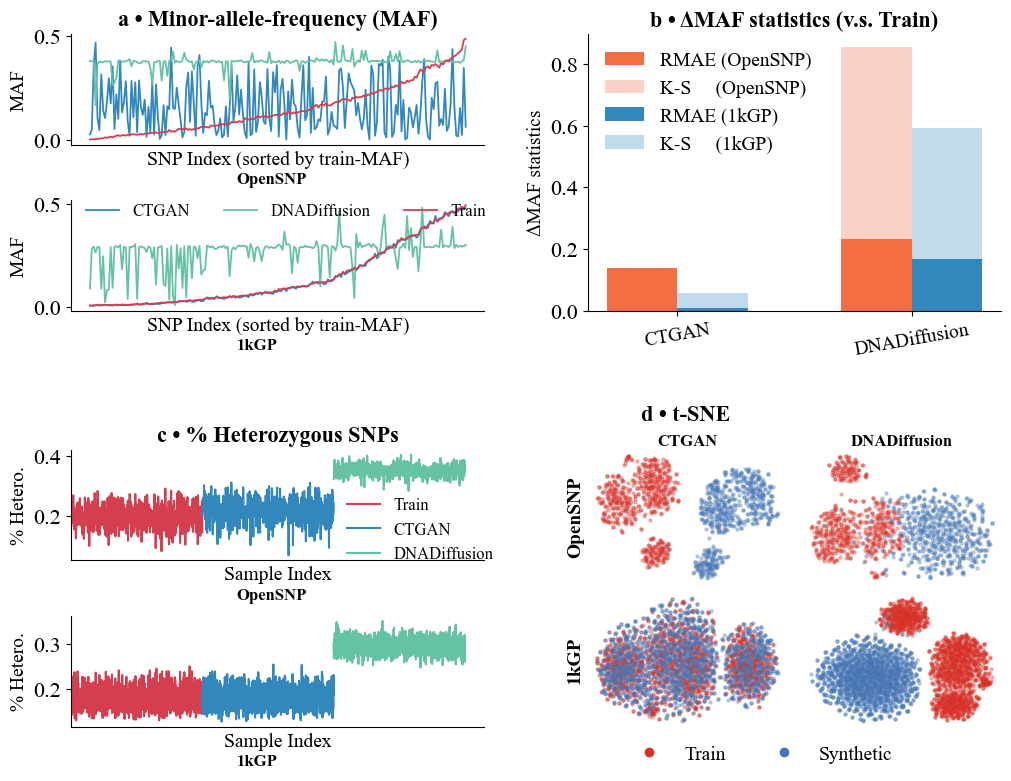

In [196]:
fig = big_panel(df_metrics, df_summary,
                snp   = 200,
                ratio = 0.75)      # pick any combination that exists

plt.show()


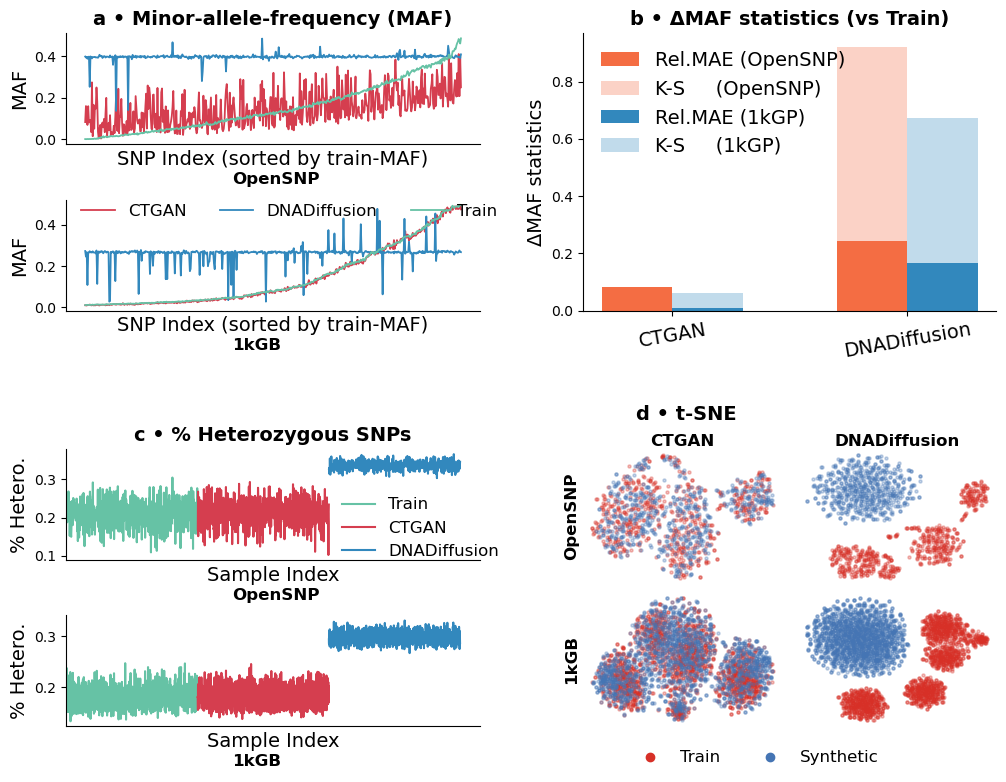

In [81]:
fig = big_panel(df_metrics, df_summary,
                snp   = 500,
                ratio = 0.75)      # pick any combination that exists

plt.show()

fig.savefig("panel_500_075.png", dpi=300, bbox_inches='tight')


# 3.2 graphs

In [82]:
import matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

In [144]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import umap.umap_ as umap

# ------------------------------------------------------------------
# 1.  Confusion matrix + error index extractor
# ------------------------------------------------------------------
def confusion_and_errors(df, show=True, savefig=None):
    """
    Parameters
    ----------
    df : DataFrame            # output of extract_confusion_matrix
           must contain columns r_label (ground‑truth) and mia_label (attack)
    show : bool
        Whether to plot the confusion matrix immediately.
    savefig : str | None
        Path to .png/.pdf file; if given the matrix will be saved there.

    Returns
    -------
    fn_idx : list[int]   indices of false‑negative rows in *df*
    fp_idx : list[int]   indices of false‑positive rows in *df*
    """
    cm = confusion_matrix(df.t_label, df.mia_label)
    
    auc = roc_auc_score(df.t_label, df.mia_score)  # assuming mia_prob is in df
    print(f"AUROC: {auc:.3f}")
    
    if show:
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=["non‑member (0)", "member (1)"]
        )
        disp.plot(cmap="Blues")
        plt.title("MIA vs. ground‑truth membership")
        if savefig:
            plt.savefig(savefig, dpi=300, bbox_inches="tight")
        plt.show()

    fn_idx = df.index[(df.t_label == 1) & (df.mia_label == 0)].tolist()
    fp_idx = df.index[(df.t_label == 0) & (df.mia_label == 1)].tolist()
    return fn_idx, fp_idx


def confusion_indices(df):
    """
    Convenience: return the four index lists that correspond to the
    classical confusion‑matrix quadrants *in the same order*:
        FN, FP, TP, TN
    """
    fn = df.index[(df.t_label == 1) & (df.mia_label == 0)].tolist()
    fp = df.index[(df.t_label == 0) & (df.mia_label == 1)].tolist()
    tp = df.index[(df.t_label == 1) & (df.mia_label == 1)].tolist()
    tn = df.index[(df.t_label == 0) & (df.mia_label == 0)].tolist()
    return fn, fp, tp, tn

# ------------------------------------------------------------------
# 2.  “Are false negatives genomically weird?”  – MAF diagnostics
# ------------------------------------------------------------------
def sample_avg_maf(geno_matrix):
    """
    Return *per‑sample* mean minor‑allele frequency (MAF).

    geno_matrix : ndarray (n_samples, n_snps) with genotype counts 0/1/2.
    """
    # minor‑allele *counts* carried by each individual
    # (0 or 1 for homo/hetero major, 2 for homo minor)
    minor_counts = np.minimum(geno_matrix, 2 - geno_matrix)

    # divide by 2 → MAF per SNP per sample ∈ {0,0.5,1}
    sample_maf = minor_counts / 2.0            # shape (n_samples, n_snps)

    # finally average over SNPs for *every* row (individual)
    return sample_maf.mean(axis=1)             # shape (n_samples,)


    
def auroc(df, *, show=True, savefig=None):
    """
    Parameters
    ----------
    df : DataFrame          # output of extract_confusion_matrix
           needs columns `t_label` (ground‑truth) and `mia_score` (continuous)
    show : bool
        If True, immediately draws the ROC curve.
    savefig : str | None
        Path to .png/.pdf; if given, the ROC figure is saved there.

    Returns
    -------
    auc : float             # area under the ROC curve
    fpr, tpr, thr : arrays  # the curve itself (useful if you want to customise plotting)
    """
    y_true  = df.r_label.values.astype(int)
    y_score = df.mia_score.values.astype(float)

    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, thr = roc_curve(y_true, y_score)

    if show:
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc).plot()
        plt.title(f"ROC curve – AUROC = {auc:0.3f}")
        if savefig:
            plt.savefig(savefig, dpi=300, bbox_inches="tight")
        plt.show()

    return auc, fpr, tpr, thr

In [224]:
def extract_confusion_matrix(overfit_logger_path, privacy_logger_path, 
                        density_estimator, embedding_method, snp_num, train_ratio, seed, data_file):
    """
    Load the pre-calculated rscore from the overfitting logger and the MIA scores (e.g., Eqn1Score)
    from the privacy logger, and extract only the test portion. In your pipeline, X_test is built by 
    concatenating train and test; therefore, the first part of the arrays corresponds to training samples.
    
    Parameters:
      overfit_logger_path: path to the overfitting logger pickle file.
      privacy_logger_path: path to the privacy logger pickle file.
      density_estimator: string (e.g., "kde", "bnaf", "freq", "discrete_kde")
      embedding_method: string (e.g., "pca", "umap", or "raw" for no embedding)
      snp_num: integer, e.g., 200, 500, or 1000.
      train_ratio: float, e.g., 0.5 or 0.75.
      seed: integer seed.
      data_file: the base folder where your real data (train, test, ref) is stored.
      
    Returns:
      A DataFrame with columns: rscore, mia_score, snp_num, train_ratio, and seed; containing only the test portion.
      Returns None if extraction fails.
    """
    # Load train and test to determine the number of training samples
    

    train_path = os.path.join(data_file, str(snp_num), str(train_ratio), f"train_{seed}.npy")
    test_path  = os.path.join(data_file, str(snp_num), str(train_ratio), f"test_{seed}.npy")
    try:
        train = np.load(train_path)
        test = np.load(test_path)
#         print(train.shape)
#         print(test.shape)
    except Exception as e:
        print(f"Error loading real data for snp {snp_num}, train_ratio {train_ratio}, seed {seed}: {e}")
        return None
    
    train_size = train.shape[0]
    t_labels = [1 for _ in range(train_size)] + [0 for _ in range(test.shape[0])]
    
    with open(privacy_logger_path, 'rb') as f:
        privacy_logger = pickle.load(f)
    # In privacy logger, keys are like "{density_estimator}_{embedding_method}_{snp_num}_{train_ratio}"
    # We can loop through keys and find one that ends with f"_{snp_num}_{train_ratio}"
    prefix = f"{density_estimator}_{embedding_method}_"
    for config_key, config_data in privacy_logger.items():
        if not config_key.startswith(prefix):
            continue

        # Remove the prefix; the remainder should be "{snp}_{train_ratio}"
        remainder = config_key[len(prefix):]
        try:
            snp_str, train_ratio_str = remainder.split('_')
            snp = int(snp_str)
            tr = float(train_ratio_str.replace('_', '.'))
        except Exception as e:
            print(f"Error parsing key {config_key}: {e}")
            continue

        if snp not in snp_nums or tr not in train_ratios:
            continue
    print(config_key)
     # For the given seed, we expect a key like "{seed}_Eqn1Score"
    mia_key = f"{seed}_Baseline_LOGAN_D1Scores"
    if mia_key not in privacy_logger[config_key]:
        print(f"MIA scores key {mia_key} not found in config {config_key}.")
        return None
    mia_scores = privacy_logger[config_key][mia_key]
    mia_labels = (mia_scores >= np.median(mia_scores)).astype(int)
    
    
    
    # Load overfitting logger to extract rscore
    with open(overfit_logger_path, 'rb') as f:
        overfit_logger = pickle.load(f)
    key_dc = f"{snp_num}_{train_ratio}"
    if key_dc not in overfit_logger:
        print(f"Overfitting logger key {key_dc} not found.")
        return None
    try:
        r_score = overfit_logger[key_dc][f"{seed}_rlevel"][0][:, 0]
    except Exception as e:
        print(f"Error extracting rscore for {key_dc}, seed {seed}: {e}")
        return None
    
    if len(r_score) < train_size:
        print(f"Error: rscore length ({len(r_score)}) is less than train_size ({train_size}).")
        return None
    #test_r_score = r_score[train_size:]
    
    # Create DataFrame for test portion
    df = pd.DataFrame({
        "rscore": r_score,
        "r_label": (r_score >= 0.25).astype(int),
        "mia_score": mia_scores,
        "mia_label": mia_labels,
        "t_label": t_labels
    })
    df["snp_num"] = snp_num
    df["train_ratio"] = train_ratio
    df["seed"] = seed
    return df

In [283]:
def maf_violinplot_with_tp(
    geno_train,
    fn_local_idx,
    tp_local_idx,
    ax=None,                 # ← NEW
    title=None,
    jitter_width=0.06,
    random_state=0,
):
    """
    geno_train     : ndarray (n_train, n_snps)
    fn_local_idx   : list[int] – indices *within geno_train* that are FN
    tp_local_idx   : list[int] – indices *within geno_train* that are TP
    ax             : a matplotlib Axes; if None, one will be created
    """

    import numpy as np
    from matplotlib import pyplot as plt

    rng = np.random.default_rng(random_state)

    # ---- compute per-sample MAF ----
    avg_maf_all = sample_avg_maf(geno_train)
    avg_maf_fn  = avg_maf_all[fn_local_idx]
    avg_maf_tp  = avg_maf_all[tp_local_idx]

    # assemble groups (skip empty ones)
    data, labels = [], []
    data.append(avg_maf_all)
    labels.append(f"All train\n(n={len(avg_maf_all)})")

    if len(avg_maf_tp):
        data.append(avg_maf_tp)
        labels.append(f"True Pos.\n(n={len(avg_maf_tp)})")

    if len(avg_maf_fn):
        data.append(avg_maf_fn)
        labels.append(f"False Neg.\n(n={len(avg_maf_fn)})")

    # create fig/ax only if not passed in
    own_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5,4))
        own_fig = True

    # violin layer
    vp = ax.violinplot(data, showmedians=False, showextrema=False)
    for body in vp["bodies"]:
        body.set_alpha(0.35)

    # box layer
    ax.boxplot(
        data,
        widths=0.25,
        patch_artist=True,
        boxprops=dict(alpha=0.75),
        medianprops=dict(color="black"),
    )

    # jittered points
    for xpos, ys in enumerate(data, 1):
        ax.scatter(
            rng.normal(xpos, jitter_width, size=len(ys)),
            ys,
            s=9,
            alpha=0.6,
        )

    # cosmetics
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=14)
    ax.set_ylabel("sample-average MAF", fontsize=14)
    if title:
        ax.set_title(title, loc="left", weight="bold", fontsize = 18)
        
    ax.grid(axis="y", ls="--", alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

    # padded y-range
    y_min = min(arr.min() for arr in data)
    y_max = max(arr.max() for arr in data)
    pad   = 0.02 * (y_max - y_min) if y_max > y_min else 0.001
    ax.set_ylim(y_min - pad, y_max + pad)

    # if we created our own fig, show it; otherwise leave that to the caller
    if own_fig:
        plt.show()
        
        
def embed_and_plot(
    geno_train,
    geno_test,
    fn_global_idx,
    fp_global_idx,
    method="umap",
    title=None,
    ax=None,                 # ← NEW
    random_state=0,
    savefig=None,
):
    """
    geno_train : ndarray (n_train, n_snps)
    geno_test  : ndarray (n_test,  n_snps)
    fn_global_idx, fp_global_idx : lists with indices *after concatenation*:
        X = np.vstack([geno_train, geno_test])
    ax : matplotlib Axes — optional, created if None
    """
    import numpy as np
    from matplotlib import pyplot as plt
    from sklearn.decomposition import PCA
    import umap

    X = np.vstack([geno_train, geno_test])

    # Reduce
    if method == "pca":
        reducer = PCA(n_components=2, random_state=random_state)
    else:  # default to UMAP
        reducer = umap.UMAP(n_components=2, random_state=random_state)

    emb = reducer.fit_transform(X)
    n_train = geno_train.shape[0]
    is_train = np.arange(X.shape[0]) < n_train

    # Create figure/ax only if not provided
    own_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
        own_fig = True

    # Scatter plot
    ax.scatter(
        emb[is_train, 0], emb[is_train, 1],
        s=35, alpha=1, c="red", label="Train"
    )
    ax.scatter(
        emb[~is_train, 0], emb[~is_train, 1],
        s=35, alpha=1, c="gray", label="Test"
    )

    # Highlight FN / FP
    if fn_global_idx:
        ax.scatter(
            emb[fn_global_idx, 0], emb[fn_global_idx, 1],
            s=35, alpha=1.0, c="deepskyblue", edgecolor="k", label="False Neg."
        )
    if fp_global_idx:
        ax.scatter(
            emb[fp_global_idx, 0], emb[fp_global_idx, 1],
            s=35, alpha=1.0, c="gold", edgecolor="k", label="False Pos."
        )

    # Cosmetics
    ax.set_xticks([])
    ax.set_yticks([])
 #   ax.set_xlabel("dim‑1", fontsize=14)
  #  ax.set_ylabel("dim‑2", fontsize=14)

    if title:
        ax.set_title(title, loc="left", weight="bold", fontsize=18)

    ax.legend(frameon=True, fontsize=14, loc='best')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if savefig:
        plt.savefig(savefig, dpi=300, bbox_inches="tight")

    if own_fig:
        plt.show()
    

In [794]:
block = (df_heat
                 .query("Dataset=='human1000' and Combo==@combo and `SNP number`==@snp")
                 .set_index("Train Ratio")[attacks])

In [213]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from umap import UMAP


# ─────────────────────────────────────────────────────────────────────────────
model_list       = ['ctgan']
dataset_list     = ['eyecolor','human1000']
train_ratios     = [0.50, 0.75]
snp_nums         = [200, 500, 1000]
seeds            = [0, 42, 50, 100, 245]

density_embedding_combos = [
    ("bnaf", "pca"),
    ("bnaf", "umap"),
    ("kde", "pca"),
    ("kde", "umap"),
    ("freq", "pca"),
    ("discrete_kde", "pca")
]

attacks = ["LOGAN_D1_auc","GAN-leaks_auc","MC_auc","DOMIA_auc"]
cmap = "RdBu_r"
norm = TwoSlopeNorm(vmin=0.45, vcenter=0.50, vmax=0.65)


all_auc = []
for ds in dataset_list:
    if ds == 'eyecolor':
        df_acc, df_auc = create_combined_privacy_df(
            model_list       = model_list,
            dataset          = ds,
            train_ratios     = train_ratios,
            snp_nums         = snp_nums,
            seeds            = seeds,
            density_embedding_combos = density_embedding_combos
        )
    else:
        df_acc, df_auc = create_combined_privacy_df(
            model_list       = model_list,
            dataset          = ds,
            train_ratios     = [0.25, 0.5, 0.75],
            snp_nums         = snp_nums,
            seeds            = seeds,
            density_embedding_combos = density_embedding_combos
        )

    df_auc['Dataset'] = ds
    df_auc['Combo']   = df_auc['Density Estimator'] + " + " + df_auc['Embedding Method']
    all_auc.append(df_auc)

heat_df = pd.concat(all_auc, ignore_index=True)

# now collapse to one row per (Dataset,Combo,Train Ratio,SNP number)
df_heat = (
    heat_df
      .groupby(["Dataset","Combo","Train Ratio","SNP number"])[attacks]
      .mean()
      .reset_index()
)

combos = df_heat["Combo"].unique()

# df_heat.to_csv("df_heat_ctgan.csv", index=False)

bnaf_pca_1000_0.75


/Users/xw273/miniconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


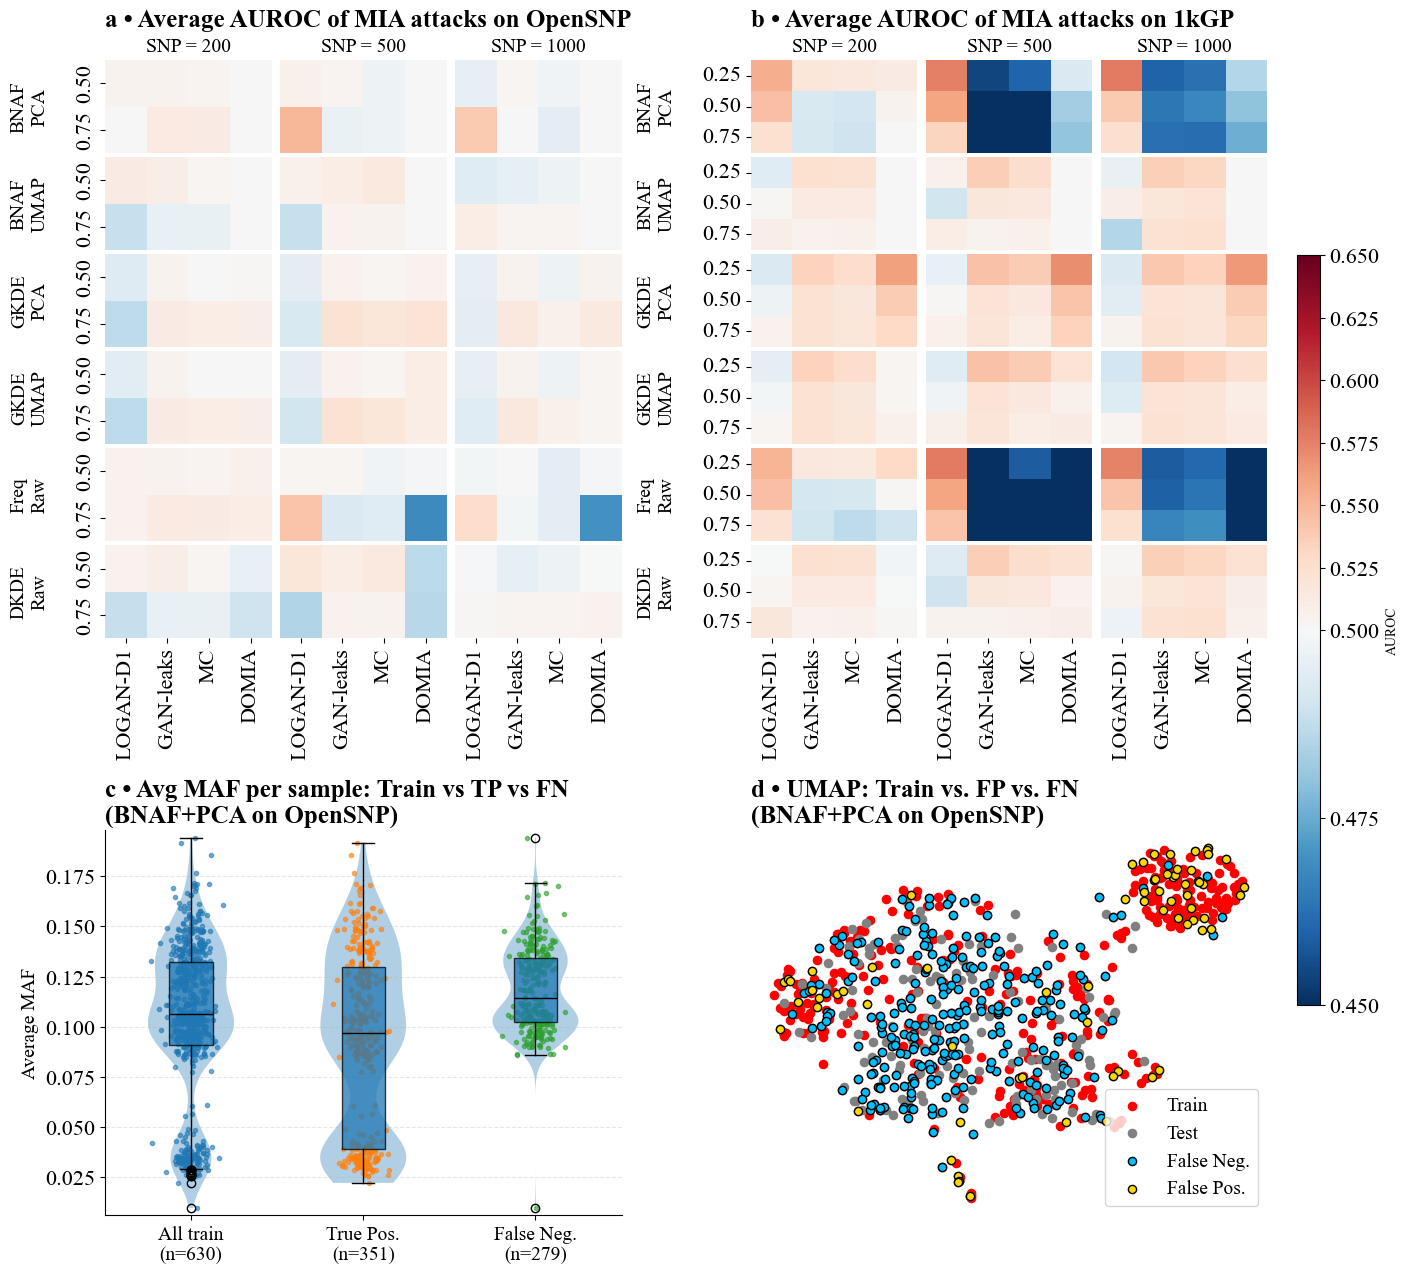

In [284]:
# ─────────────────────────────────────────────────────────────────────────────
# 2) Create 2×2 figure
# ─────────────────────────────────────────────────────────────────────────────

from sklearn.metrics import roc_auc_score

import matplotlib as mpl

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
#plt.rcParams["font.weight"] = 'bold'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16


combosNames = ['BNAF\nPCA', 'BNAF\nUMAP', 'GKDE\nPCA', 'GKDE\nUMAP', 'Freq\nRaw', 'DKDE\nRaw']
MIANames = ['LOGAN-D1', 'GAN-leaks', 'MC', 'DOMIA']


fig = plt.figure(figsize=(15,15))
GS  = gridspec.GridSpec(2,2,height_ratios=[3, 2], wspace=0.25, hspace=0.4, figure=fig)

# ──────────────────────────────────────────────────────────────────────
# A) small grid of heatmaps (combos × snp_nums)
# ──────────────────────────────────────────────────────────────────────

axA_outer = fig.add_subplot(GS[0,0])
axA_outer.axis("off")            # hide its ticks & frame

# now you can set_title on this dummy axes
axA_outer.set_title("a • Average AUROC of MIA attacks on OpenSNP", loc="left", weight="bold", fontsize = 18, pad = 24)
subA = GS[0,0].subgridspec(len(combos), len(snp_nums),
                           wspace=0.05, hspace=0.05)

for r, combo in enumerate(combos):
    for c, snp in enumerate(snp_nums):
        ax = fig.add_subplot(subA[r, c])
        block = (df_heat
                 .query("Dataset=='eyecolor' and Combo==@combo and `SNP number`==@snp")
                 .set_index("Train Ratio")[attacks]
                 .reindex(train_ratios))
        sns.heatmap(block.values, ax=ax,
                    cmap=cmap, norm=norm,
                    annot=False, fmt=".2f",
                    cbar=False,
                    xticklabels=MIANames if r==len(combos)-1 else [],
                    yticklabels=[f"{tr:.2f}" for tr in train_ratios] if c==0 else [])
        
        if c == 0:
            ax.set_ylabel(f"{combosNames[r]}\n", fontsize=14)
      #  yticklabels=[f"{combosNames[r]}\n{tr:.2f}" for tr in train_ratios] if c == 0 else [])
        if r == 0:
            ax.set_title(f"SNP = {snp}", fontsize=14)
   #     ax.set_xticks([]); ax.set_yticks([])

# ─────────────────────────────────────────────────────────────────────────────
# B) 1kGP heatmaps
# ─────────────────────────────────────────────────────────────────────────────

axB_outer = fig.add_subplot(GS[0,1])
axB_outer.axis("off")            # hide its ticks & frame

axB_outer.set_title("b • Average AUROC of MIA attacks on 1kGP",
                    #\n(density-estimator + embedding)", \
                    loc="left", weight="bold", fontsize = 18, pad = 24)
subB = GS[0,1].subgridspec(len(combos), len(snp_nums),
                           wspace=0.05, hspace=0.05)

for r, combo in enumerate(combos):
    for c, snp in enumerate(snp_nums):
        ax = fig.add_subplot(subB[r, c])
        block = (df_heat
                 .query("Dataset=='human1000' and Combo==@combo and `SNP number`==@snp")
                 .set_index("Train Ratio")[attacks]
                 .reindex([0.25, 0.5, 0.75]))
       # print(block)
        
        sns.heatmap(block.values, ax=ax,
                    cmap=cmap, norm=norm,
                    annot=False, fmt=".2f",
                    cbar=False,
                    xticklabels=MIANames if r==len(combos)-1 else [],
                    yticklabels=[f"{tr:.2f}" for tr in [0.25, 0.5, 0.75]] if c==0 else [])
        
                #yticklabels=[f"{combosNames[r]}\n{tr:.2f}" for tr in [0.25, 0.5, 0.75]] if c == 0 else [])
        if c == 0:
            ax.set_ylabel(f"{combosNames[r]}\n", fontsize=14)
            
        if r == 0:
            ax.set_title(f"SNP = {snp}", fontsize=14)
        


# ─────────────────────────────────────────────────────────────────────────────
# shared colorbar (to the right)
# ─────────────────────────────────────────────────────────────────────────────
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.50])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.set_label("AUROC", fontsize=10)


# ─────────────────────────────────────────────────────────────────────────────
# C) Sample‐average MAF violin (train vs TP vs FN)
# ─────────────────────────────────────────────────────────────────────────────

overfit_logger_path = "../results_folder/eyecolor/ref_data_overfitting_logger_bio_train.pkl"
privacy_logger_path = "../results_folder/eyecolor/ctgan/bnaf_pca_privacy_logger_2.pkl"
snp_num, train_ratio, seed = 1000, 0.75, 245
data_file = "../data/eyecolor/real"

density_estimator = "bnaf"
embedding_method = "pca"

geno_train = np.load(os.path.join(data_file, str(snp_num),
                                  str(train_ratio), f"train_{seed}.npy"))

df_conf = extract_confusion_matrix(
    overfit_logger_path, privacy_logger_path,
    density_estimator, embedding_method,
    snp_num, train_ratio, seed, data_file
)

# _, _ = confusion_and_errors(df_conf)

fn_idx, fp_idx, tp_idx, tn_idx = confusion_indices(df_conf)
train_size = geno_train.shape[0]
fn_train = [i for i in fn_idx if i < train_size]
tp_train = [i for i in tp_idx if i < train_size]

axC = fig.add_subplot(GS[1,0])
maf_violinplot_with_tp(
    geno_train, fn_train, tp_train,
    ax=axC,
    title="c • Avg MAF per sample: Train vs TP vs FN\n(BNAF+PCA on OpenSNP)"
)
axC.set_ylabel("Average MAF")
axC.set_xlabel("")


# ─────────────────────────────────────────────────────────────────────────────
# D) UMAP of FP vs FN (bottom‐right)
# ─────────────────────────────────────────────────────────────────────────────
geno_test = np.load(os.path.join(data_file, str(snp_num),
                                 str(train_ratio), f"test_{seed}.npy"))


# Combine FN and FP indices into global indices (based on stacking train + test)
n_train = geno_train.shape[0]

axD = fig.add_subplot(GS[1,1])
embed_and_plot(
    geno_train=geno_train,
    geno_test=geno_test,
    fn_global_idx=fn_idx,
    fp_global_idx=fp_idx,
    method="umap",
    title="d • UMAP: Train vs. FP vs. FN\n(BNAF+PCA on OpenSNP)",
    ax=axD,
    random_state=42
)

plt.show()

In [309]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from umap import UMAP

# ─────────────────────────────────────────────────────────────────────────────
model_list       = ['bitdiffusion']
dataset_list     = ['eyecolor','human1000']
train_ratios     = [0.50, 0.75]
snp_nums         = [200, 500, 1000]
seeds            = [0, 42, 50, 100, 245]

density_embedding_combos = [
    ("bnaf", "pca"),
    ("bnaf", "umap"),
    ("kde", "pca"),
    ("kde", "umap"),
    ("freq", "pca"),
    ("discrete_kde", "pca")
]

attacks = ["LOGAN_D1_auc","GAN-leaks_auc","MC_auc","DOMIA_auc"]
cmap = "RdBu_r"
norm = TwoSlopeNorm(vmin=0.45, vcenter=0.50, vmax=0.65)


all_auc = []
for ds in dataset_list:
    if ds == 'eyecolor':
        df_acc, df_auc = create_combined_privacy_df(
            model_list       = model_list,
            dataset          = ds,
            train_ratios     = train_ratios,
            snp_nums         = snp_nums,
            seeds            = seeds,
            density_embedding_combos = density_embedding_combos
        )
    else:
        df_acc, df_auc = create_combined_privacy_df(
            model_list       = model_list,
            dataset          = ds,
            train_ratios     = [0.25, 0.5, 0.75],
            snp_nums         = snp_nums,
            seeds            = seeds,
            density_embedding_combos = density_embedding_combos
        )

    df_auc['Dataset'] = ds
    df_auc['Combo']   = df_auc['Density Estimator'] + " + " + df_auc['Embedding Method']
    all_auc.append(df_auc)

heat_df = pd.concat(all_auc, ignore_index=True)

# now collapse to one row per (Dataset,Combo,Train Ratio,SNP number)
df_heat = (
    heat_df
      .groupby(["Dataset","Combo","Train Ratio","SNP number"])[attacks]
      .mean()
      .reset_index()
)

combos = df_heat["Combo"].unique()



kde_umap_1000_0.75


/Users/xw273/miniconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


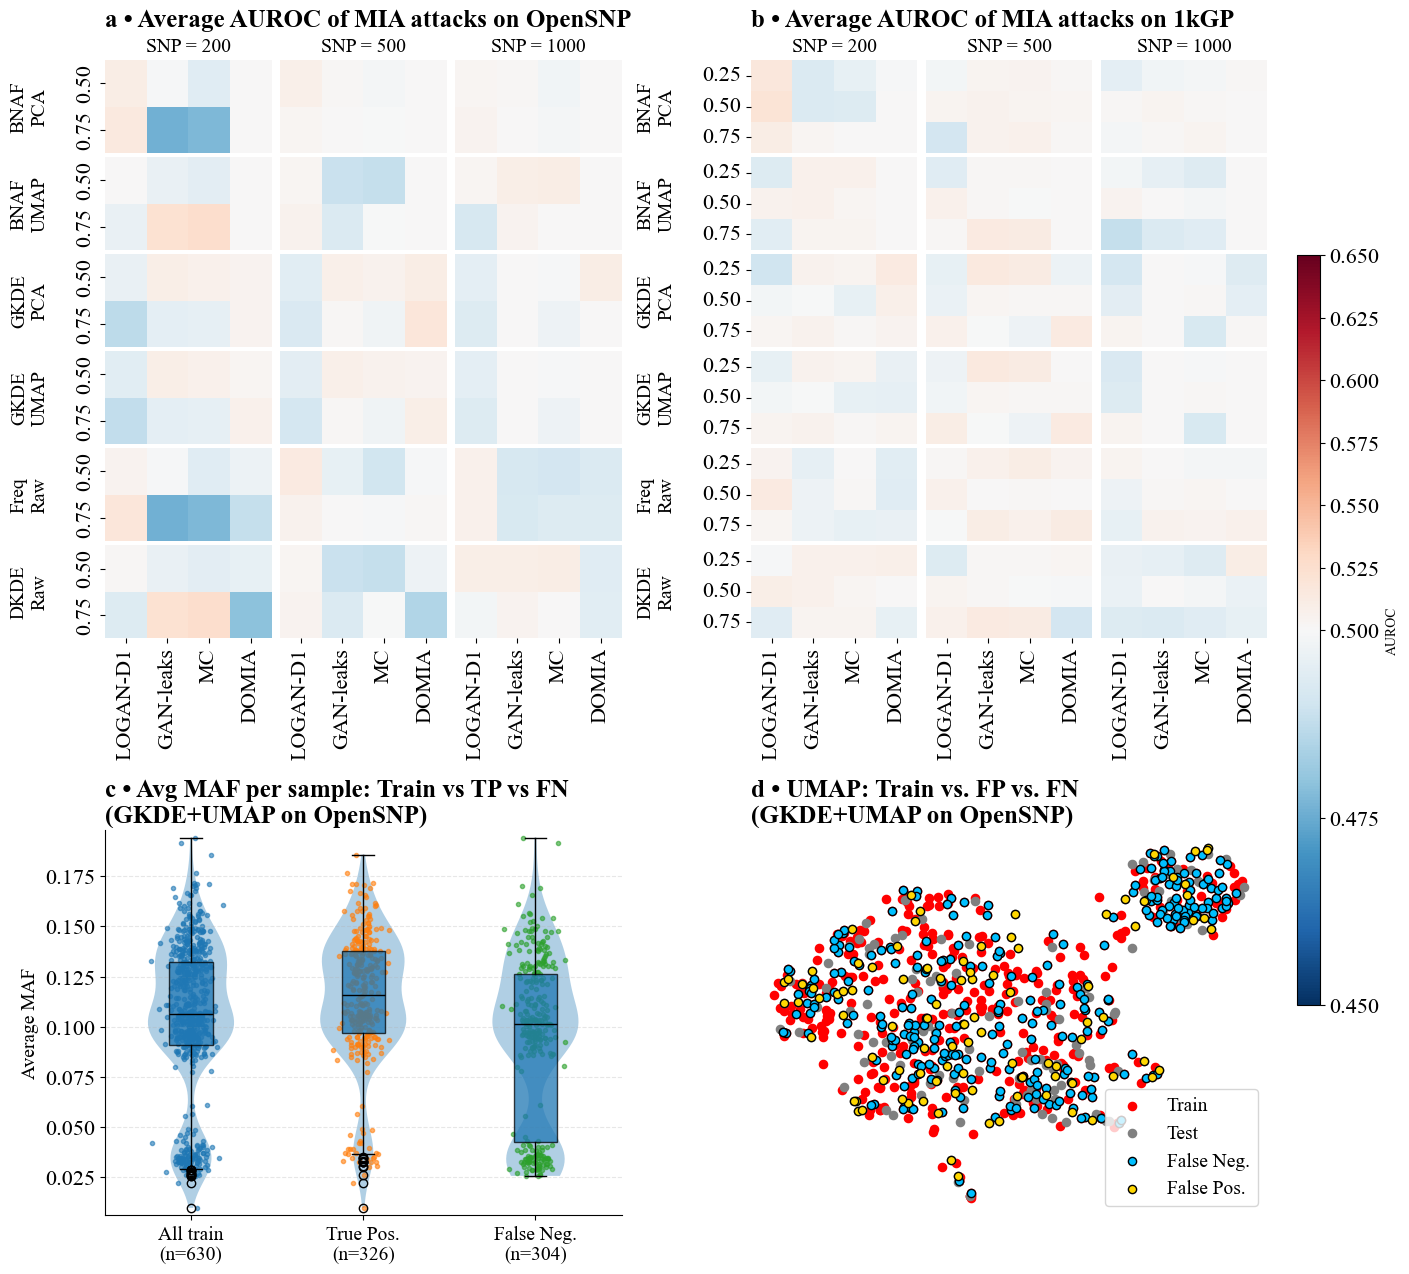

In [311]:
# ─────────────────────────────────────────────────────────────────────────────
# 2) Create 2×2 figure
# ─────────────────────────────────────────────────────────────────────────────

from sklearn.metrics import roc_auc_score

import matplotlib as mpl

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
#plt.rcParams["font.weight"] = 'bold'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16


combosNames = ['BNAF\nPCA', 'BNAF\nUMAP', 'GKDE\nPCA', 'GKDE\nUMAP', 'Freq\nRaw', 'DKDE\nRaw']
MIANames = ['LOGAN-D1', 'GAN-leaks', 'MC', 'DOMIA']


fig = plt.figure(figsize=(15,15))
GS  = gridspec.GridSpec(2,2,height_ratios=[3, 2], wspace=0.25, hspace=0.4, figure=fig)

# ──────────────────────────────────────────────────────────────────────
# A) small grid of heatmaps (combos × snp_nums)
# ──────────────────────────────────────────────────────────────────────

axA_outer = fig.add_subplot(GS[0,0])
axA_outer.axis("off")            # hide its ticks & frame

axA_outer.set_title("a • Average AUROC of MIA attacks on OpenSNP", loc="left", weight="bold", fontsize = 18, pad = 24)
subA = GS[0,0].subgridspec(len(combos), len(snp_nums),
                           wspace=0.05, hspace=0.05)

for r, combo in enumerate(combos):
    for c, snp in enumerate(snp_nums):
        ax = fig.add_subplot(subA[r, c])
        block = (df_heat
                 .query("Dataset=='eyecolor' and Combo==@combo and `SNP number`==@snp")
                 .set_index("Train Ratio")[attacks]
                 .reindex(train_ratios))
        sns.heatmap(block.values, ax=ax,
                    cmap=cmap, norm=norm,
                    annot=False, fmt=".2f",
                    cbar=False,
                    xticklabels=MIANames if r==len(combos)-1 else [],
                    yticklabels=[f"{tr:.2f}" for tr in train_ratios] if c==0 else [])
        
        if c == 0:
            ax.set_ylabel(f"{combosNames[r]}\n", fontsize=14)
      #  yticklabels=[f"{combosNames[r]}\n{tr:.2f}" for tr in train_ratios] if c == 0 else [])
        if r == 0:
            ax.set_title(f"SNP = {snp}", fontsize=14)
   #     ax.set_xticks([]); ax.set_yticks([])

# ─────────────────────────────────────────────────────────────────────────────
# B) 1kgp heatmaps
# ─────────────────────────────────────────────────────────────────────────────

axB_outer = fig.add_subplot(GS[0,1])
axB_outer.axis("off")            # hide its ticks & frame

axB_outer.set_title("b • Average AUROC of MIA attacks on 1kGP",
                    #\n(density-estimator + embedding)", \
                    loc="left", weight="bold", fontsize = 18, pad = 24)

subB = GS[0,1].subgridspec(len(combos), len(snp_nums),
                           wspace=0.05, hspace=0.05)

for r, combo in enumerate(combos):
    for c, snp in enumerate(snp_nums):
        ax = fig.add_subplot(subB[r, c])
        block = (df_heat
                 .query("Dataset=='human1000' and Combo==@combo and `SNP number`==@snp")
                 .set_index("Train Ratio")[attacks]
                 .reindex([0.25, 0.5, 0.75]))
       # print(block)
        
        sns.heatmap(block.values, ax=ax,
                    cmap=cmap, norm=norm,
                    annot=False, fmt=".2f",
                    cbar=False,
                    xticklabels=MIANames if r==len(combos)-1 else [],
                    yticklabels=[f"{tr:.2f}" for tr in [0.25, 0.5, 0.75]] if c==0 else [])
        
                #yticklabels=[f"{combosNames[r]}\n{tr:.2f}" for tr in [0.25, 0.5, 0.75]] if c == 0 else [])
        if c == 0:
            ax.set_ylabel(f"{combosNames[r]}\n", fontsize=14)
            
        if r == 0:
            ax.set_title(f"SNP = {snp}", fontsize=14)
        

# ─────────────────────────────────────────────────────────────────────────────
# shared colorbar (to the right)
# ─────────────────────────────────────────────────────────────────────────────
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.50])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.set_label("AUROC", fontsize=10)


# ─────────────────────────────────────────────────────────────────────────────
# C) Sample‐average MAF violin (train vs TP vs FN)
# ─────────────────────────────────────────────────────────────────────────────


overfit_logger_path = "../results_folder/eyecolor/ref_data_overfitting_logger_bio_train.pkl"
privacy_logger_path = "../results_folder/eyecolor/bitdiffusion/kde_umap_privacy_logger_2.pkl"
snp_num, train_ratio, seed = 1000, 0.75, 245
data_file = "../data/eyecolor/real"

density_estimator = "kde"
embedding_method = "umap"

geno_train = np.load(os.path.join(data_file, str(snp_num),
                                  str(train_ratio), f"train_{seed}.npy"))

df_conf = extract_confusion_matrix(
    overfit_logger_path, privacy_logger_path,
    density_estimator, embedding_method,
    snp_num, train_ratio, seed, data_file
)

#_, _ = confusion_and_errors(df_conf)

fn_idx, fp_idx, tp_idx, tn_idx = confusion_indices(df_conf)
train_size = geno_train.shape[0]
fn_train = [i for i in fn_idx if i < train_size]
tp_train = [i for i in tp_idx if i < train_size]

axC = fig.add_subplot(GS[1,0])
maf_violinplot_with_tp(
    geno_train, fn_train, tp_train,
    ax=axC,
    title="c • Avg MAF per sample: Train vs TP vs FN\n(GKDE+UMAP on OpenSNP)"
)
axC.set_ylabel("Average MAF")
axC.set_xlabel("")


# ─────────────────────────────────────────────────────────────────────────────
# D) UMAP of FP vs FN (bottom‐right)
# ─────────────────────────────────────────────────────────────────────────────
geno_test = np.load(os.path.join(data_file, str(snp_num),
                                 str(train_ratio), f"test_{seed}.npy"))


# Combine FN and FP indices into global indices (based on stacking train + test)
n_train = geno_train.shape[0]
axD = fig.add_subplot(GS[1,1])
embed_and_plot(
    geno_train=geno_train,
    geno_test=geno_test,
    fn_global_idx=fn_idx,
    fp_global_idx=fp_idx,
    method="umap",
    title="d • UMAP: Train vs. FP vs. FN\n(GKDE+UMAP on OpenSNP)",
    ax=axD,
    random_state=42
)


plt.show()

In [312]:
fig.savefig("./figs/3.2/DNADiff_mia_analysis_figure.png", bbox_inches="tight", dpi=300)

# 3.3 

In [172]:
def create_dataframe_dc(model_list, dataset, case, train_ratios, snp_nums, seeds):
    all_rows = []  # List to collect all rows

    for model in model_list:
        for snp_num in snp_nums:
            for train_ratio in train_ratios:
                for seed in seeds:
                # Construct the file path
                    
                    if model in ['GT', 'Original', 'Train', 'Validation', 'Test', 'Reference']:
                        if case == 'overall':    
                            file_path = f'../results_folder/{dataset}/ref_data_overfitting_logger.pkl'
                        elif case == 'sig':
                            file_path = f'.../results_folder/{dataset}/ref_data_overfitting_logger_g1.pkl'
                        else:                            
                            file_path = f'../results_folder/{dataset}/ref_data_overfitting_logger_g2.pkl'

                        
                    else:
                        if case == 'overall':
                            
                            file_path = f'../results_folder/{dataset}/{model}/overfitting_logger.pkl'
                        elif case == 'sig':
                            file_path = f'../results_folder/{dataset}/{model}/overfitting_logger_g1.pkl'
                        else:
                            file_path = f'../results_folder/{dataset}/{model}/overfitting_logger_g2.pkl'



                    with open(file_path, 'rb') as pf:
                        overfitting_logger = pickle.load(pf)
                        
                    r_score = overfitting_logger[f"{snp_num}_{train_ratio}"][f"{seed}_rlevel"][0][:, 0]
                    d_score = overfitting_logger[f"{snp_num}_{train_ratio}"][f"{seed}_dlevel"]

                        
                       
                        
                    row = [model, train_ratio, snp_num, seed, r_score, d_score]
                    all_rows.append(row)
        
                
    # Create a DataFrame
    df = pd.DataFrame(all_rows, columns=['Model', 'Train Ratio','SNP number', 'Seed', 'rscore', 'CT'])
    
    return df

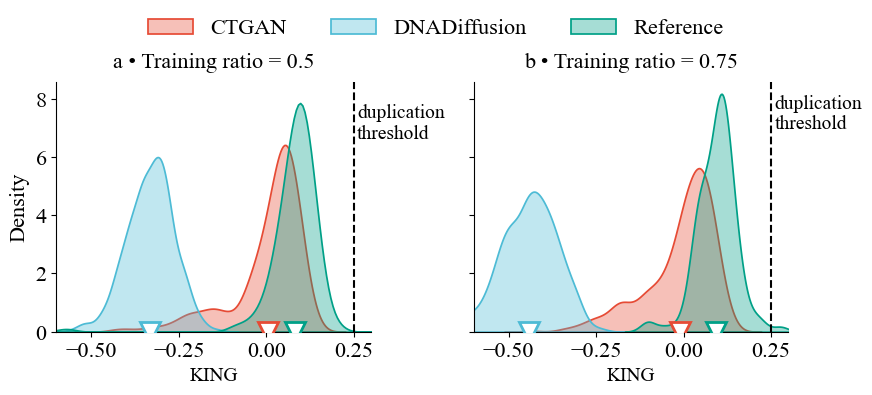

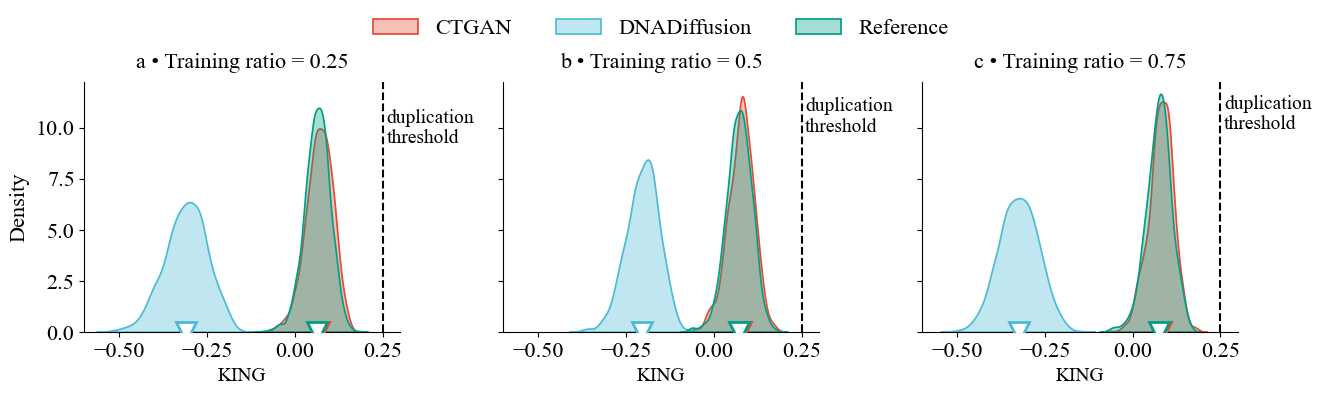

In [178]:
import matplotlib as mpl

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
#plt.rcParams["font.weight"] = 'bold'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

    
for dataset in ['eyecolor', 'human1000']:
    
    if dataset == 'eyecolor':
        train_ratios = [0.5, 0.75]
        
    else:
        
        train_ratios = [0.25, 0.5, 0.75]
    
    df = create_dataframe_dc(['ctgan','bitdiffusion', 'Reference'], dataset, 'overall', \
                      train_ratios, [200, 500, 1000], [0, 42, 50, 100, 245])
        
    snp_number = 1000
    model_names = ['CTGAN', 'Bitdiffusion', 'Reference']
   # color_list = [ '#f1515e', '#f77f00', '#1dbde6']
    color_list = ['#E64B35', '#4DBBD5', "#00A087"]
    


    filtered = df[(df['SNP number']==snp_number) & (df['Seed']==42)]
    
    fig, axes = plt.subplots(
            nrows=1, ncols=len(train_ratios),
            figsize=(4.5*len(train_ratios), 3.8), sharey=True
    )

    for idx, (ax, ratio) in enumerate(zip(axes, train_ratios)):
        sub = filtered.query("`Train Ratio` == @ratio")

        # KDEs -------------------------------------------------------
        for mdl, clr, lbl in zip(["ctgan", "bitdiffusion", "Reference"],
                         color_list,
                         ["CTGAN", "DNADiffusion", "Reference"]):

            # explode → 1 value per row
            vals = (
                sub.loc[sub.Model == mdl, "rscore"]
                   .explode()          # split list/array to rows
                   .astype(float)      # ensure numeric
                   .dropna()
            )

            sns.kdeplot(vals, ax=ax, fill=True, alpha=.35,
                        linewidth=1.25, color=clr,
                        label=lbl if ratio == train_ratios[0] else None,
                        common_norm=False)

            # mean of exploded values → scalar
            mu = vals.mean()
            ax.plot([mu], [0], marker="v", mfc="white", mec=clr, mew=2, ms=14, zorder=5)
            
    
        dup_x = .25
        ax.axvline(dup_x, ls="--", lw=1.5, color="k")
        ax.text(dup_x + 0.01,            # small x-offset so it doesn’t sit on the line
        ax.get_ylim()[1]*0.95,   # near the top of the axis
        "duplication\nthreshold",
        fontsize=14, ha="left", va="top")
        # cosmetics
        ax.set_xlim(-.6, .3)
        ax.set_xlabel("KING", fontsize=14)
        ax.set_title(f"{['a', 'b', 'c'][idx]} • Training ratio = {ratio}", fontsize=16, pad=10)
        if ax is axes[0]:
            ax.set_ylabel("Density", fontsize=16)
        else:
            ax.set_ylabel("")
        sns.despine(ax=ax)

    # single legend above all panels
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=3, frameon=False,
               loc="upper center", bbox_to_anchor=(0.5, 1.08))

    plt.tight_layout()
    plt.savefig(f'./figs/3.3/{dataset}_king_ratios.png',
               dpi=300, bbox_inches="tight")
    plt.show()

# 3.4

In [390]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def extract_confusion_matrix_all(
    overfit_logger_path, privacy_logger_path,
    density_estimator, embedding_method,
    snp_num, train_ratio, seed, data_file,
    attack_name
):
    """
    Loads r_score (KING) and mia_score for *one* attack.
    Returns a DataFrame of length (train_size + test_size) with columns:
       rscore, mia_score, mia_label, is_member, plus metadata.
    Returns None on any error.
    """
    # 1. load real splits to know train_size
    train_path = os.path.join(data_file, str(snp_num), str(train_ratio), f"train_{seed}.npy")
    test_path  = os.path.join(data_file, str(snp_num), str(train_ratio), f"test_{seed}.npy")
    try:
        train = np.load(train_path)
        test  = np.load(test_path)
    except Exception as e:
        print("  → REAL DATA ERROR:", e)
        return None
    train_size = train.shape[0]

    # 2. pull MIA scores
    try:
        with open(privacy_logger_path, 'rb') as f:
            priv = pickle.load(f)
    except Exception as e:
        print("  → PRIVACY LOGGER ERROR:", e)
        return None

    # find the right config key
    prefix = f"{density_estimator}_{embedding_method}_"
    target_suffix = f"_{snp_num}_{train_ratio}"
    config_key = next(
        (k for k in priv if k.startswith(prefix) and k.endswith(target_suffix)),
        None
    )
    if config_key is None:
        print("  → NO PRIVACY CONFIG FOR", density_estimator, embedding_method, snp_num, train_ratio)
        return None

    # assemble the mia key
    if attack_name != 'DOMIAS':
        mia_key = f"{seed}_Baseline_{attack_name}Scores"
    else:
        mia_key = f"{seed}_Eqn2Score"

    if mia_key not in priv[config_key]:
        print("  → NO ATTACK KEY", mia_key, "in", config_key)
        return None

    mia_scores = np.array(priv[config_key][mia_key])
    mia_labels = (mia_scores >= np.median(mia_scores)).astype(int)

    # 3. pull rscore
    try:
        with open(overfit_logger_path, 'rb') as f:
            over = pickle.load(f)
    except Exception as e:
        print("  → OVERFIT LOGGER ERROR:", e)
        return None

    of_key = f"{snp_num}_{train_ratio}"
    if of_key not in over:
        print("  → NO OVERFIT KEY", of_key)
        return None

    try:
        r_score = np.ravel(over[of_key][f"{seed}_rlevel"][0])
    except Exception as e:
        print("  → ERROR EXTRACTING r_score for", of_key, e)
        return None

    if len(r_score) != train_size + test.shape[0]:
   #     print("  → LENGTH MISMATCH r_score", len(r_score), train_size + test.shape[0])
        r_score = r_score[-(train_size+test.shape[0]):]
        #return None

    # 4. build df
    df = pd.DataFrame({
        "rscore":    r_score,
        "mia_score": mia_scores,
        "mia_label": mia_labels,
        "is_member": [1]*train_size + [0]*test.shape[0]
    })
    # attach metadata
    df["density"]     = density_estimator
    df["embedding"]   = embedding_method
    df["snp_num"]     = snp_num
    df["train_ratio"] = train_ratio
    df["seed"]        = seed
    df["attack"]      = attack_name
    return df

# ─────────────────────────────────────────────────────────────────────────────
# Main loop: run Pearson on every combo
# ─────────────────────────────────────────────────────────────────────────────
models      = ['ctgan','bitdiffusion']
datasets    = ['eyecolor','human1000']
densities   = ['bnaf','kde','freq','discrete_kde']
embeddings  = ['pca','umap']
snps        = [200,500,1000]
seeds       = [0,42,50,100,245]
attacks     = ['LOGAN_D1','gan_leaks','MC','DOMIAS']

train_ratio_map = {
    'eyecolor':  [0.25, 0.50],
    'human1000': [0.25, 0.50, 0.75],
}

all_results = []
for model, ds, density, emb, snp, tr, seed, attack in itertools.product(
    models, datasets, densities, embeddings, snps,
    [], [], attacks 
):
   
    break

# better: nested loops
all_results = []
for model in models:
    for ds in datasets:
        for density in densities:
            for emb in embeddings:
                for snp in snps:
                    for tr in train_ratio_map[ds]:
                        for seed in seeds:
                            for attack in attacks:
                                overfit_path = f"../results_folder/{ds}/{model}/ref_data_overfitting_logger_bio.pkl"
                                privacy_path = f"../results_folder/{ds}/{model}/{density}_{emb}_privacy_logger_2.pkl"
                                data_file    = f"../data/{ds}/real"

                                df_conf = extract_confusion_matrix_all(
                                    overfit_path, privacy_path,
                                    density, emb,
                                    snp, tr, seed, data_file,
                                    attack_name=attack
                                )
                                if df_conf is None:
                                    continue

                                # Pearson r between rscore & mia_score
                                r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)

                                all_results.append({
                                    "model":       model,
                                    "dataset":     ds,
                                    "density":     density,
                                    "embedding":   emb,
                                    "snp":         snp,
                                    "train_ratio": tr,
                                    "seed":        seed,
                                    "attack":      attack,
                                    "pearson_r":   r_val,
                                    "p_value":     p_val,
                                    "N":           len(df_conf),
                                })

# assemble final DataFrame
df_pearson = pd.DataFrame(all_results)
print(df_pearson)

# optionally, pivot or summarize:
summary = df_pearson.groupby(
    ["model","dataset","density","embedding","snp","train_ratio","attack"]
)["pearson_r","p_value"].agg(["mean","std"]).reset_index()
print(summary)

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/1000/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/500/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_0.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_42.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/eyecolor/real/200/0.25/train_50.npy'
  → REAL DATA ERROR: [Errno 2] No such file or directory: '../data/e

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)
/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jyt

/var/folders/jc/gpmxwymd351cckl6cvjf72vh5jytlq/T/ipykernel_71447/1473351899.py:152: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, p_val = pearsonr(df_conf.rscore, df_conf.mia_score)


             model    dataset       density embedding   snp  train_ratio  \
0            ctgan   eyecolor          bnaf       pca   200         0.50   
1            ctgan   eyecolor          bnaf       pca   200         0.50   
2            ctgan   eyecolor          bnaf       pca   200         0.50   
3            ctgan   eyecolor          bnaf       pca   200         0.50   
4            ctgan   eyecolor          bnaf       pca   200         0.50   
...            ...        ...           ...       ...   ...          ...   
3835  bitdiffusion  human1000  discrete_kde      umap  1000         0.75   
3836  bitdiffusion  human1000  discrete_kde      umap  1000         0.75   
3837  bitdiffusion  human1000  discrete_kde      umap  1000         0.75   
3838  bitdiffusion  human1000  discrete_kde      umap  1000         0.75   
3839  bitdiffusion  human1000  discrete_kde      umap  1000         0.75   

      seed     attack  pearson_r   p_value     N  
0        0   LOGAN_D1   0.035642  0.

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [391]:
df_pearson.to_csv('./figs/3.4/pearson_memory_vs_mia.csv', index= False)

In [348]:
summary = (
    df_pearson
    .groupby(
        ["model","dataset","density","embedding","snp","train_ratio","attack"]
    )
    .agg({
        'pearson_r': ['mean','std'],
        'p_value'  : ['mean','std']
    })
    .reset_index()
)
print(summary)

            model    dataset density embedding   snp train_ratio    attack  \
                                                                             
0    bitdiffusion   eyecolor    bnaf       pca   200        0.50    DOMIAS   
1    bitdiffusion   eyecolor    bnaf       pca   200        0.50  LOGAN_D1   
2    bitdiffusion   eyecolor    bnaf       pca   200        0.50        MC   
3    bitdiffusion   eyecolor    bnaf       pca   500        0.50    DOMIAS   
4    bitdiffusion   eyecolor    bnaf       pca   500        0.50  LOGAN_D1   
..            ...        ...     ...       ...   ...         ...       ...   
571         ctgan  human1000     kde      umap  1000        0.50  LOGAN_D1   
572         ctgan  human1000     kde      umap  1000        0.50        MC   
573         ctgan  human1000     kde      umap  1000        0.75    DOMIAS   
574         ctgan  human1000     kde      umap  1000        0.75  LOGAN_D1   
575         ctgan  human1000     kde      umap  1000        0.75

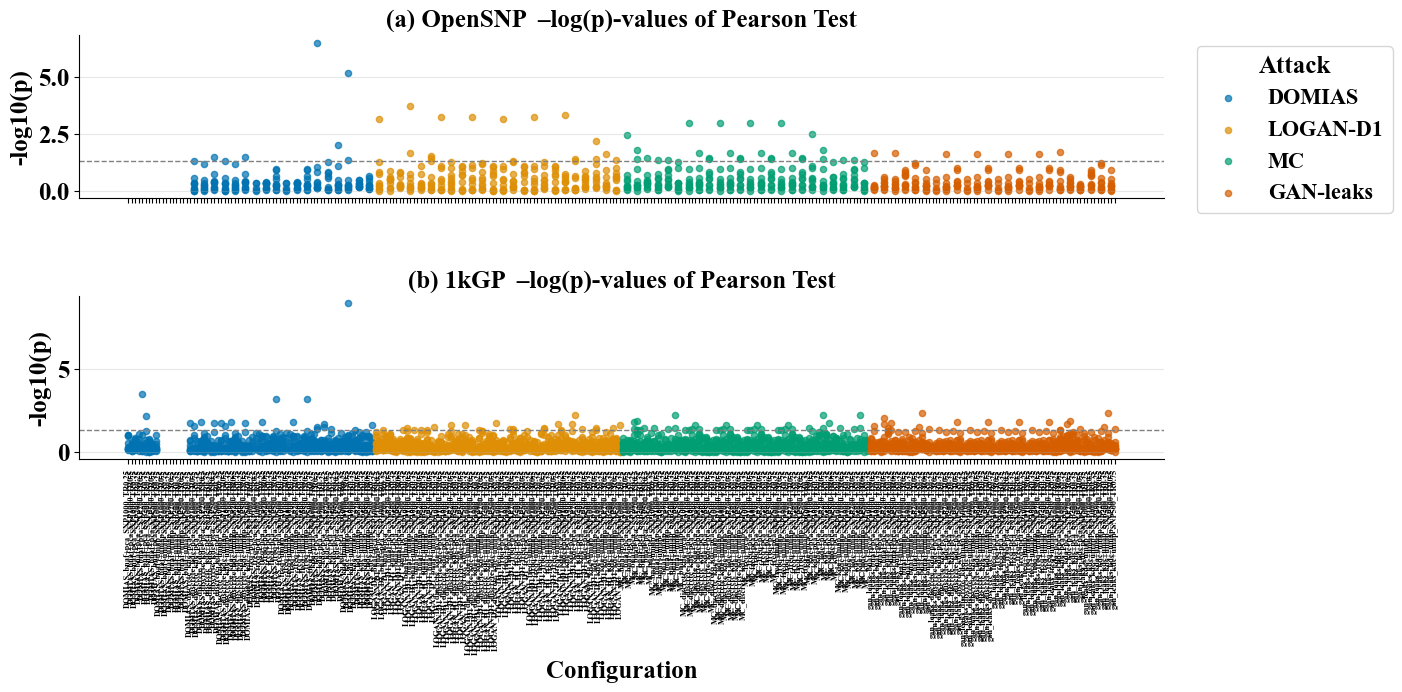

In [395]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
# 2) Set default font sizes and weights
plt.rcParams['font.size']       = 18
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.titleweight']= 'bold'
plt.rcParams['axes.labelsize']  = 18
plt.rcParams['axes.labelweight']= 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

# prepare a single “config” column for the x-axis
df = df_pearson.copy()
df['logp'] = -np.log10(df['p_value'].replace(0, np.nan))
df['config'] = (
    df['attack'] + "_" +
    df['density'] + "+" +
    df['embedding'] +
    "_SNP" + df['snp'].astype(str) +
    "_TR" + df['train_ratio'].astype(str)
)
configs = sorted(df['config'].unique())
xpos_map = {cfg:i for i,cfg in enumerate(configs)}
df['x'] = df['config'].map(xpos_map)

# make a vertical 2×1 figure
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
datasets = df['dataset'].unique()

dataset_names = {'eyecolor':'OpenSNP',
                'human1000':'1kGP'}

attack_names = {'LOGAN_D1':'LOGAN-D1',
                'MC':'MC',
                'gan_leaks':'GAN-leaks',
                'DOMIAS':'DOMIAS'
               }

ods = {'eyecolor':'(a)',
                'human1000':'(b)'}
for ax, ds in zip(axes, datasets):
    sub = df[df['dataset'] == ds]
    attacks = sorted(sub['attack'].unique())
    #palette = plt.cm.tab10(np.linspace(0,1,len(attacks)))
    palette = sns.color_palette("colorblind", n_colors=len(attacks))

    for col, atk in zip(palette, attacks):
        atk_sub = sub[sub['attack']==atk]
        ax.scatter(atk_sub['x'], atk_sub['logp'],
                   c=[col], alpha=0.7, label=attack_names[atk], s=20)

    ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1)
    ax.set_title(f"{ods[ds]} {dataset_names[ds]}  –log(p)-values of Pearson Test", loc='center')
    ax.set_ylabel("-log10(p)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
 #   ax.spines['bottom'].set_visible(False)
  #  ax.spines['left'].set_visible(False)
    ax.grid(axis='y', alpha=0.3)

# bottom plot controls the shared x-axis
axes[-1].set_xticks(range(len(configs)))
axes[-1].set_xticklabels(configs, rotation=90, fontsize=8)
axes[-1].set_xlabel("Configuration")

# legend outside the top panel
axes[0].legend(title="Attack", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=16)

# grab the bottom‐most Axes
ax = axes[-1]    # or however you refer to your bottom subplot

# explicitly set all the xticks at the integer positions
ax.set_xticks(np.arange(len(configs)))

# now set the labels, rotate 90°, center‐aligned, tiny font
ax.set_xticklabels(
    configs,
    rotation=90,
    ha='center',
    fontsize=6,      # you can go smaller if you like
    va='top'
)

# give yourself extra breathing room at the bottom:
plt.subplots_adjust(bottom=0.35)
plt.subplots_adjust(hspace=0.6)

plt.savefig(f'./figs/3.4/pearson_memory_vs_mia.png',
               dpi=300, bbox_inches="tight")

# finally, redraw
plt.draw()

In [399]:
threshold = -np.log10(0.05)
df[df['logp']>threshold]

,model,dataset,density,embedding,snp,train_ratio,seed,attack,pearson_r,p_value,N,logp,config,x
10,ctgan,eyecolor,bnaf,pca,200,0.50,50,MC,-0.083021,0.016032,841,1.795012,MC_bnaf+pca_SNP200_TR0.5,148
30,ctgan,eyecolor,bnaf,pca,500,0.50,50,MC,-0.071544,0.038046,841,1.419694,MC_bnaf+pca_SNP500_TR0.5,151
48,ctgan,eyecolor,bnaf,pca,1000,0.50,50,LOGAN_D1,-0.116728,0.000695,841,3.158215,LOGAN_D1_bnaf+pca_SNP1000_TR0.5,73
49,ctgan,eyecolor,bnaf,pca,1000,0.50,50,gan_leaks,-0.079250,0.021536,841,1.666825,gan_leaks_bnaf+pca_SNP1000_TR0.5,217
50,ctgan,eyecolor,bnaf,pca,1000,0.50,50,MC,-0.099989,0.003700,841,2.431751,MC_bnaf+pca_SNP1000_TR0.5,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,bitdiffusion,human1000,discrete_kde,umap,500,0.50,42,gan_leaks,-0.050494,0.015443,2300,1.811273,gan_leaks_discrete_kde+umap_SNP500_TR0.5,250
3755,bitdiffusion,human1000,discrete_kde,umap,500,0.50,100,DOMIAS,-0.049090,0.018551,2300,1.731621,DOMIAS_discrete_kde+umap_SNP500_TR0.5,34
3791,bitdiffusion,human1000,discrete_kde,umap,1000,0.25,50,DOMIAS,0.048883,0.019053,2300,1.720031,DOMIAS_discrete_kde+umap_SNP1000_TR0.25,27
3810,bitdiffusion,human1000,discrete_kde,umap,1000,0.50,50,MC,0.041458,0.046809,2300,1.329675,MC_discrete_kde+umap_SNP1000_TR0.5,172
